In [92]:
from shapely.geometry import Polygon, MultiPolygon
from skimage.color import grey2rgb
from skimage import measure
import skimage
import numpy as np
import random
import json
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from PIL import Image
import urllib.request
pylab.rcParams['figure.figsize'] = 5, 5

# needed for validation
import cv2
import maskrcnn_benchmark
from maskrcnn_benchmark.structures.segmentation_mask import SegmentationMask
from matplotlib.patches import Rectangle
from pycocotools.coco import *
import torch
from maskrcnn_benchmark.structures.bounding_box import BoxList

In [70]:
ROOT = "/home/maxsen/DEEPL/"

## Generating data for Mask R-CNN
In this script, the data set is generated. For the input a .JSON annotation file from LabelBox with coordinates in XY-format are needed.

In [71]:
# images are downloaded from the URLs saved in the JSON file

def download_img(anno_file, img_dir):
    
    anno = json.load(open(anno_file))
    for s in anno:
        
        name = s['External ID']
        url = s['Labeled Data']
        urllib.request.urlretrieve(url, img_dir + name)
        print('downloading %s'%(name))
    
    # show random image and determine the image size
    img = Image.open(img_dir + random.choice(os.listdir(img_dir)))
    img_size = img.size
    print("Random_img")
    plt.imshow(img);plt.axis('off')
    plt.show()
    
    return img_size
    


In [72]:
# get annotations from the data set

def labelbox_annotations_parser(annotations_dir,annotation_file,img_size):
    
    """
    Remember that for labelbox:
    - origin (0,0) of the reference system in bottom left corner like
    cartesian system
    - labelbox can label objects outside the image so the coords
    need to be trimmed to the image size
    - This parser consider that all the images are square and same image size
    
    """
    
    annotations = json.load(open(annotations_dir+annotation_file))
    
    # Parse the annotation of the images done using labelbox.io
    # into a better formatted dict
    # Check with the company  where is the origin

    # create incremental number for all the identified objects
    obj_idx = 0

    # create a labels list
    labels_list = [] 
    labels_dict = {}

    # Reformatted dict
    annotations_dict = {}

    # Masks reference
    masks_urls_dict = {}
    
    # Loop through all the images
    # TODO: Check to skip non annotated images 
    for annotation_data in annotations:

        # Avoid error when empty images
        if isinstance(annotation_data['Label'],dict):
        # save the image id
            img_id = annotation_data['External ID']
            annotations_dict[img_id] = {}
            masks_urls_dict[img_id] = {}

            # create subdict with labels
            for lab in annotation_data['Label'].keys():
                if lab not in labels_list:
                    labels_list.append(lab) 
                annotations_dict[img_id][lab] = {}

            # Create labels dict with reference number starting from 1
            # because zero is for background
            lab_idx = 1
            for lab in labels_list:
                labels_dict[lab] = lab_idx
                lab_idx += 1

            # loop through the labels and convert the coords in a list of tuples
            for lab, objs in annotation_data['Label'].items():

                for obj_coords in objs:
                    coords = [tuple(coord_pair.values()) for coord_pair in obj_coords]

                    # Convert the coords in numpy array
                    coords = np.array(coords)
                    # labelbox reference system has (0,0) on the bottom left corner
                    # need to correct in order to have skimage system
                
                    # Flip cartesian y-axis
                    coords = np.abs(coords-np.array([0,img_size]))
                
                    # Swap x,y converting to [rr,cc] system
                    coords[:,[0,1]] = coords[:,[1,0]]
                
                    # Remove values that are ouside the range
                    coords[coords<0] = 0
                
                    # Remove the point out of the upper limit of the edges
                    coords[coords>img_size] = img_size
                
                    annotations_dict[img_id][lab][obj_idx] = coords
                    obj_idx +=1

        
#        # Collect all the url for the masks
#        for lab in annotation_data['Masks'].keys():
#            masks_urls_dict[img_id][lab] = annotation_data['Masks'][lab]
            
    return annotations_dict, masks_urls_dict, labels_dict


# chunk the images with the desired dimension and convert them to hstack numpy array

def chunking_labeled_images(number_chunks_dimension,class_names, img_raw,chunked_dir,annotations_dict):


    # Get image ids from annotations
    image_ids = list(annotations_dict.keys())

    for image_id in image_ids:

        # Define the image path
        image_path = img_raw + image_id

        # segmented regions
        polygons = annotations_dict[image_id]


        # Determine the size of the image
        image = skimage.io.imread(image_path)
        
        ## plt.imshow(image)
        # plt.show()
        
        # Convert the image to uint8
        image = skimage.util.img_as_ubyte(image)
        # image = skimage.color.grey2rgb(image)
        height, width = image.shape[:2]

        # Load and create masks array

        # Determine how many objects of the different classes have been segmented
        instance_count = 0
        for lab in polygons:
            instance_count += len(list(polygons[lab].values()))

        mask = np.zeros([height, width, instance_count],
                        dtype=np.uint8)

        class_ids = []
        mask_layer = 0
        #print(polygons)
        for lab, pgs in polygons.items():
            
            # Get the class id
            #print(class_names)
            class_id = class_names.index(lab)

            for obj_num, coords in pgs.items():
                
                rr, cc = skimage.draw.polygon(coords[:,0], coords[:,1])
                mask[rr, cc, mask_layer] = class_id
                mask_layer += 1
                class_ids.append(class_id)

        class_ids = np.array(class_ids)

        # account for colored images, greyscale images have shape for example (1024, 1024) 
        # and colored images have  (1024, 1024, 3)
        if len(image.shape)>2:
            print(image.shape)
            dstack = np.dsplit(image,3)
            stack1 = dstack[0][:, :, 0]
            stack2 = dstack[1][:, :, 0]
            stack3 = dstack[2][:, :, 0]
            image_mask = np.insert(mask, 0, stack1, axis=2)
            image_mask = np.insert(image_mask, 0, stack2, axis=2)
            image_mask = np.insert(image_mask, 0, stack3, axis=2)
        else:
            image_mask = np.insert(mask,0,image,axis=2)
        
        sstack = np.dsplit(image_mask, image_mask.shape[2])

        # stack image with masks
        # consider that we are collecting square images and only even number of cuts
        hsplits = np.split(image_mask,number_chunks_dimension,axis=0)
        total_images = []
        for split in hsplits:
                total_images.append(np.split(split,number_chunks_dimension,axis=1))
        total_images = [img for cpl in total_images for img in cpl] 

        # Chunk the images and the segmented data
        for idx,image_chunk in enumerate(total_images):
            image_chunks_ids = []
            mask = image_chunk != 0
            planes_to_keep = np.flatnonzero((mask).sum(axis=(0,1)))
            # Make sure that the image has labeled objects
            if planes_to_keep.size:
                image_chunk_trimmed = image_chunk[:,:,planes_to_keep]
                image_chunk_trimmed_id = image_id.split('.')[0]+'chunk'+str(idx)

                np.save(chunked_dir + image_chunk_trimmed_id, image_chunk_trimmed)


In [73]:
# folder for raw annotations
ANNO = ROOT + 'annotation/'

# path raw annotation
start_annotation_file = 'export_henry.json'

# download all the raw images
downloaded_images = ROOT + 'henry_part1/raw_img/'
#img_size = download_img(ANNO + start_annotation_file, downloaded_images)
print(img_size)


annotations_dict, masks_urls_dict, labels_dict = labelbox_annotations_parser(ANNO, start_annotation_file, img_size[0])
#print(labels_dict, masks_urls_dict)
#annotations_dict = rm_certain_masks(annotations_dict, list_to_take)
#print(annotations_dict.keys())

(2048, 2048)


In [74]:
# Number of chunks to create
# 2x2 or 4x4 etc.....
# it must be even

number_chunks_dimension = 2
class_names = ['BG']
_ = [class_names.append(i) for i in labels_dict]
print(class_names)

# dir to save the chunks
CHUNKS = ROOT + "henry_part1/chunks/"

# do the chunking

#chunking_labeled_images(number_chunks_dimension,
#                       class_names, downloaded_images,
#                       CHUNKS,
#                       annotations_dict)


# visualize the chunks to validate
'''
for s in os.listdir(CHUNKS):
    print(s)
    
    data = np.load(CHUNKS + s)
    if True:
        li = np.dsplit(data, data.shape[2])
        plt.imshow(np.dstack((li[0], li[0], li[0])))
        plt.show()
        print(len(li))
        for r in range(1, len(li)):
            plt.imshow(np.dstack((li[r]*100, li[r]*100, li[r]*100)))
            plt.show()
'''    

['BG', 'nuclei', 'undefined', 'clusters']


'\nfor s in os.listdir(CHUNKS):\n    print(s)\n    \n    data = np.load(CHUNKS + s)\n    if True:\n        li = np.dsplit(data, data.shape[2])\n        plt.imshow(np.dstack((li[0], li[0], li[0])))\n        plt.show()\n        print(len(li))\n        for r in range(1, len(li)):\n            plt.imshow(np.dstack((li[r]*100, li[r]*100, li[r]*100)))\n            plt.show()\n'

## Functions own

In [75]:
# make sub mask for each instance
def make_sub_masks(np_array):

    
    sub_masks = {}
    
    width, height, dim = np_array.shape
    
    # go through the np.array pixel-wise
    for x in range(width):
        for y in range(height):
            
            # Get the pixel values from the numpy array
            a = np_array[y,x,0]
            b = np_array[y,x,1]
            c = np_array[y,x,2]
            # get pixel in RGB format
            pixel = (a,b,c)
            
            # if pixel is not background/black
            if pixel != (0,0,0):
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                
                if sub_mask is None:
                    
                    # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)
    
    return sub_masks

In [76]:
# make annotation for mask
def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd = 0):
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation = "low")
    
    segmentations = []
    polygons = []
    
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make Polygon and simplify it
        
        #contour = contour.dot([[-1,0],[0,-1]])
        #contour = abs(contour)
        poly = Polygon(contour)
        
        poly = poly.simplify(1.0, preserve_topology = False)
        
        # transform IMPORTANT
        
        
        polygons.append(poly)
        
        #print("contour: ", contour)
        #print("poly.wkt: ", poly.wkt)
        
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)
        
    # combine polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    # write everything in coco-annotation-
    # like format
    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': int(image_id),
        'category_id': int(category_id),
        'id': int(annotation_id),
        'bbox': bbox,
        'area': area
    }
    
    return annotation

In [77]:
def combine_masks_boxes(np_array, filename, width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0, augment = True):
        
        if augment == True:
            chunk_id = str(filename[-len("00.npy"):-len(".npy")])  
            print(filename)
            
            # this really depends on the data that is being used here
            # if augmentation is applied, a second value is added from 0 to 7 to account for the rotation and flipping of the images
            
            if filename.startswith('Nuclei_DRG_Hyb2_pos_'):
                img_id = str(filename[len("Nuclei_DRG_Hyb2_pos_"):-len("chunk00.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Nuclei_DRG_Hyb2_pos_")] + str(image_id) + ".png"
                   
            elif filename.startswith('Nuclei_SN') or filename.startswith('Nuclei_RN'):
                img_id = str(filename[len("Nuclei_SN_Hyb2_pos_"):-len("chunk00.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Nuclei_SN_Hyb2_pos_")] + str(image_id) + ".png"

            elif filename.startswith('Raw_Nuclei'):
                img_id = str(filename[len("Raw_Nuclei_"):-len("chunk00.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Raw_Nuclei_")] + str(image_id) + ".png"
            
            elif filename.startswith('Nuclei_EXP20180416_60X_pos_'):
                img_id = str(filename[len("Nuclei_EXP20180416_60X_pos_"):-len("chunk00.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Nuclei_EXP20180416_60X_pos_")] + str(image_id) + ".png"

            elif filename.startswith('B'):
                img_id = str(filename[len("BE87_"):-len("chunk00.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("BE87_")] + str(image_id) + ".png"
                
            elif filename.startswith('AMEXP20181106_hyb1_DAPI_pos_'):
                img_id = str(filename[len("AMEXP20181106_hyb1_DAPI_pos_"):-len("_predchunk00.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("AMEXP20181106_hyb1_DAPI_pos_")] + str(image_id) + ".png"

            elif filename.startswith('Merged_'):
                img_id = str(filename[len("Merged_"):-len("chunk00.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Merged_")] + str(image_id) + ".png"
                print(filename)
                print(img_id)
                print(image_id)
        else:
            chunk_id = str(filename[-len("0.npy"):-len(".npy")])
            
            # depending on dataset used      
            # here it is only one value
            if filename.startswith('Nuclei_SN') or filename.startswith('Nuclei_RN'):
                img_id = str(filename[len("Nuclei_SN_Hyb2_pos_"):-len("chunk0.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Nuclei_SN_Hyb2_pos_")] + str(image_id) + ".png"
                print(filename, image_id)
                
            elif filename.startswith('Nuclei_DRG_Hyb2_pos_'):
                img_id = str(filename[len("Nuclei_DRG_Hyb2_pos_"):-len("chunk0.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Nuclei_DRG_Hyb2_pos_")] + str(image_id) + ".png"
                
            elif filename.startswith('Nuclei_EXP20180416_60X_pos_'):
                img_id = str(filename[len("Nuclei_EXP20180416_60X_pos_"):-len("chunk0.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Nuclei_EXP20180416_60X_pos_")] + str(image_id) + ".png"
                
            elif filename.startswith('Raw_Nuclei'):
                img_id = str(filename[len("Raw_Nuclei_"):-len("chunk0.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Raw_Nuclei_")] + str(image_id) + ".png"

            elif filename.startswith('B'):
                img_id = str(filename[len("BE87_"):-len("chunk0.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("BE87_")] + str(image_id) + ".png"
                
            elif filename.startswith('AMEXP20181106_hyb1_DAPI_pos'):
                img_id = str(filename[len("AMEXP20181106_hyb1_DAPI_pos_"):-len("_predchunk0.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("AMEXP20181106_hyb1_DAPI_pos_")] + str(image_id) + ".png"
            elif filename.startswith('Merged_'):
                img_id = str(filename[len("Merged_"):-len("_chunk0.npy")])
                image_id = (img_id + chunk_id)
                filename = filename[0:len("Merged_")] + str(image_id) + ".png"
                print(filename)
                print(img_id)
            
        # full image_id, i.e. 150 see above
        array_split = np.split(np_array, dim, axis=2)
        
        # images without segmentations have shape (1024, 1024, 1)
        # updated filename with correct image_id
        
        annotations = []
        
        # account for non-empty annotation
        if True:
            image = {
                'id' : int(image_id),
                'width' : width,
                'height' : height,
                'file_name' : filename,
                'license' : None,
                'flickr_url' : None,
                'coco_url' : None,
                'date_captured' : None
            }
            
            #images.append(image)
            
            # save ground truth
            #print(len(array_split))
            
            # use this when handling colored images
            ground_truth = np.dstack((array_split[2],array_split[1], array_split[0]))

            ground_truth = grey2rgb(np.squeeze(array_split[0], axis = 2))
            plt.imshow(ground_truth)
            plt.show()
            im = Image.fromarray(ground_truth)
            im.save(images_to_save_folder + filename)
            
            # change to 3 if colored
            for i in range(1, len(array_split)):
                try:
                    stacked_array = np.dstack((array_split[i], array_split[i], array_split[i]))
                    sub_masks = make_sub_masks(stacked_array)
                    
                    for color, sub_mask in sub_masks.items():
                        #print(category_ids)
                        cat_id = category_ids[color]
                        #print(cat_id)
                        annotation = create_sub_mask_annotation(sub_mask, image_id, cat_id, annotation_id, is_crowd)
                        annotations.append(annotation)
                        #print(annotation_id)
                        annotation_id += 1
                        
                # some instances call an Attribute Error, because their shape is abnormal        
                except AttributeError:
                    print("Attribute Error was raised, check shape of file")
            return image, annotations, annotation_id
            
            

In [78]:
# combine both scripts above
def combine(categories, info, licenses, 
            category_ids, annotation_file, 
            chunks_dir,
            images_to_save_folder,
            is_crowd = 0, limit = None, AUGMENT = False):
    
    # set annotations and images
    annotations = []
    images = []
    annotation_id = 1
    
    # go through folder of chunks in .npy format
    # i.e. Nuclei_SN_Hyb2_pos_15chunk0.npy
    # IMPORTANT
    # the image_id will be 150, 15 for the image number
    # and 0 for the first chunk of the whole image
    # this is because the image_id has to be integer
    # chunks were created like this:  0 1
    #                                 2 3

    # option to limit
    x = 0
    
    for one_file in os.listdir(chunks_dir):
        if limit:
            if x <= limit:
                print('pass')
                pass
            else:
                print('continue')
                continue
    
                

        print("File {} is processed".format(one_file))
        filename = one_file
        #print(filename[:-4] + '0.npy')
        
        # load numpy file
        #print(chunks_dir + one_file)
        np_array = np.load(chunks_dir + one_file)
        height, width, dim = np_array.shape
        print(np_array.shape)

        # do augmentation
        if AUGMENT == True and dim > 2:    # numpy.rot90(m, k=1, axes=(0, 1))
            
            # offline augmentation
            np_array1 = np.rot90(np_array, k=1, axes=(0, 1))
            np_array2 = np.rot90(np_array, k=2, axes=(0, 1))
            np_array3 = np.rot90(np_array, k=3, axes=(0, 1))
            np_array4 = np.flip(np_array, axis=0)
            np_array5 = np.flip(np_array1, axis=0)
            np_array6 = np.flip(np_array2, axis=0)
            np_array7 = np.flip(np_array3, axis=0)    
            
            #np_array, filename, width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0, augment = True)
            
            image, annos, anno_id = combine_masks_boxes(np_array, filename[:-4] + '0.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array1, filename[:-4] + '1.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array2, filename[:-4] + '2.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array3, filename[:-4] + '3.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array4, filename[:-4] + '4.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array5, filename[:-4] + '5.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array6, filename[:-4] + '6.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array7, filename[:-4] + '7.npy', width, height, dim, images_to_save_folder, annotation_id, category_ids, is_crowd = 0)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            x += 1
            
        elif AUGMENT == False and dim > 1:
            image, annos, anno_id = combine_masks_boxes(np_array, filename, 
                                                        width, height, dim, images_to_save_folder, 
                                                        annotation_id, category_ids, is_crowd = 0, augment = False)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            print("Masks and Annotations obtained")
            x += 1
        else:
            print('No annos')
        
    # save all annotations to json file
    print("write annotation to: ", annotation_file)
    with open(annotation_file, "w") as write_file:
        json.dump(
                {"info":info,
                 "annotations":[item for sublist in annotations for item in sublist], 
                 "images":images,
                 "licenses":licenses,
                 "categories":categories}, write_file)

## Transform image names to numbers so one can convert to COCO-format

In [79]:
# this can be used or modified if the filenames do not contain id numbers

def trans(image_folder, anno_file):
    files = os.listdir(image_folder)
    anno = json.load(open(anno_file))
    dict_trans = {name: name[2:6] + '_' + str(i) for i, name in enumerate(files, 40)}
    [print(i, dict_trans[i]) for i in dict_trans]
    for name in dict_trans:
        new = dict_trans[name] + '.png'
        os.rename(image_folder + name, image_folder + new)
    for i, s in enumerate(anno):
        if s['External ID'] in dict_trans:
            anno[i]['External ID'] = dict_trans[anno[i]['External ID']] + '.png'
    with open(anno_file[:-5] + '_coco.json', 'w') as w:
        json.dump(anno, w)
    # print conversion dictionary
    

## Set variables and paths

### can be optimized much more, just a preliminary solution

In [83]:
# 1 is for nuclei, 2 is for undefined and 3 is for cluster

category_ids_polyt = {
                '(1, 1, 1)':1,
                '(2, 2, 2)':2,
                '(3, 3, 3)':3,
                '(4, 4, 4)':4
               }
category_ids_nuclei = {
                '(1, 1, 1)':1,
                '(2, 2, 2)':2,
                '(3, 3, 3)':3
                }

# pass categories in coco json file

categories_nuclei = [{'supercategory': 'nuclei', 'id': 1, 'name': 'nuclei'}, 
              {'supercategory': 'undefined', 'id': 2, 'name': 'undefined'}, 
              {'supercategory': 'clusters', 'id': 3, 'name': 'clusters'}]

categories_polyt = [
    {'supercategory': 'Cell', 'id': 1, 'name': 'Cell'}, 
    {'supercategory': 'Undefined', 'id': 3, 'name': 'Undefined'}, 
    {'supercategory': 'Clusters', 'id': 2, 'name': 'Clusters'},
    {'supercategory': 'Junk', 'id': 4, 'name': 'Junk'}
]

# pass licenses, I usually did not pass any
licenses = []



# pass info
info = {'year': 2018, 
        'version': None, 
        'description': 'RNA staining segmentation SV', 
        'contributor': 'maximilian.senftleben@stud.ki.se', 
        'url': 'labelbox.com', 
        'date_created': '2018-04-12T09:46:52.000Z'
       }

# dir of chunks in .npy format
CHUNKS = ROOT + '/henry_part1/chunks_smaller/'

# chunked images to save
NEW_CHUNK_DIR = ROOT + '/henry_part1/new_img/'

# define annotation file
anno_file = ROOT + '/henry_part1/anno_test.json'

File Raw_Nuclei_36chunk3.npy is processed
(1024, 1024, 14)


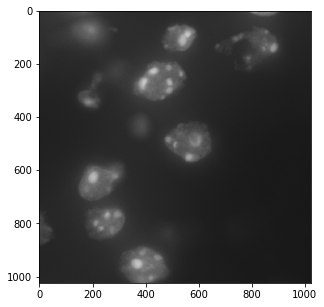

Masks and Annotations obtained
File Nuclei_SN_Hyb2_pos_67chunk0.npy is processed
(1024, 1024, 35)
Nuclei_SN_Hyb2_pos_670.png 670


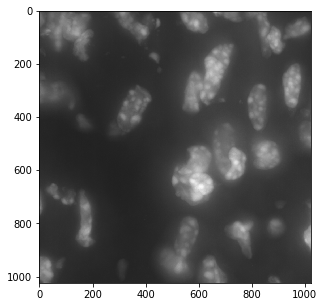

Masks and Annotations obtained
File Raw_Nuclei_36chunk0.npy is processed
(1024, 1024, 23)


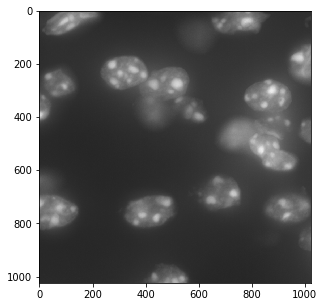

Masks and Annotations obtained
File Nuclei_DRG_Hyb2_pos_60chunk2.npy is processed
(1024, 1024, 26)


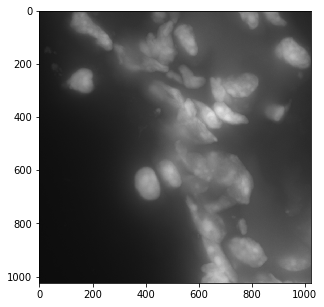

Masks and Annotations obtained
File Nuclei_DRG_Hyb2_pos_60chunk0.npy is processed
(1024, 1024, 24)


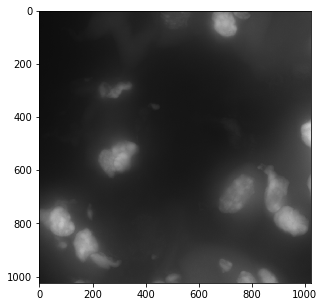

Masks and Annotations obtained
File Nuclei_EXP20180416_60X_pos_30chunk0.npy is processed
(1024, 1024, 18)


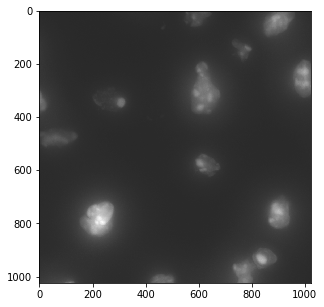

Masks and Annotations obtained
write annotation to:  /home/maxsen/DEEPL//henry_part1/anno_test.json


In [84]:
combine(categories_nuclei, info, licenses, 
        category_ids_nuclei, anno_file, 
        CHUNKS, NEW_CHUNK_DIR, AUGMENT = False)


## Validate the datasat

In [85]:
def imshow(img, result, save_path=None):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img)
    plt.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(result)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches = 'tight')
        plt.show()
    else:
        plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Raw_Nuclei_363.png


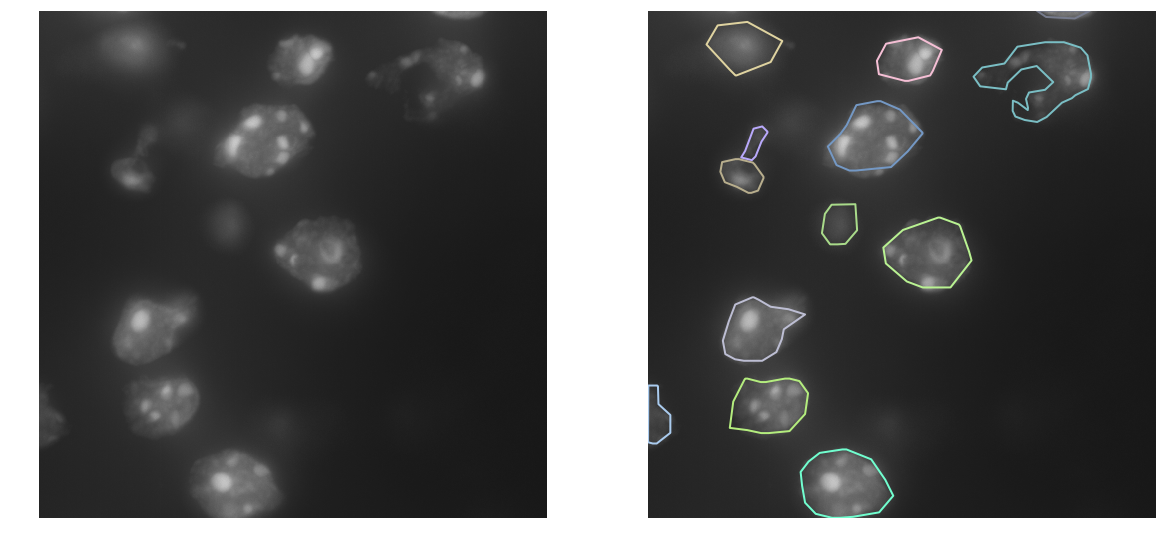

Nuclei_SN_Hyb2_pos_670.png


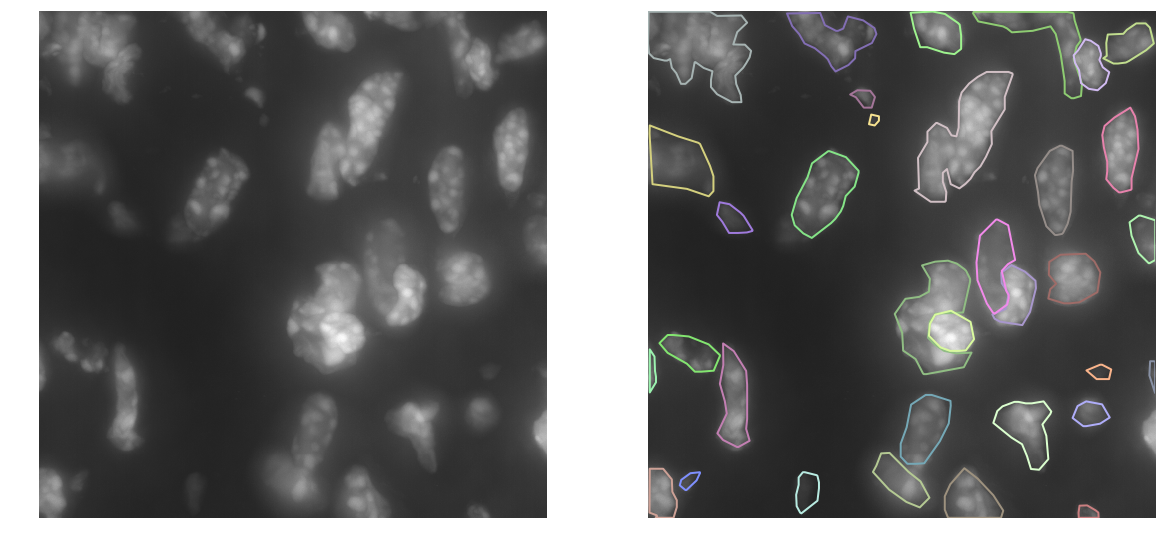

Raw_Nuclei_360.png


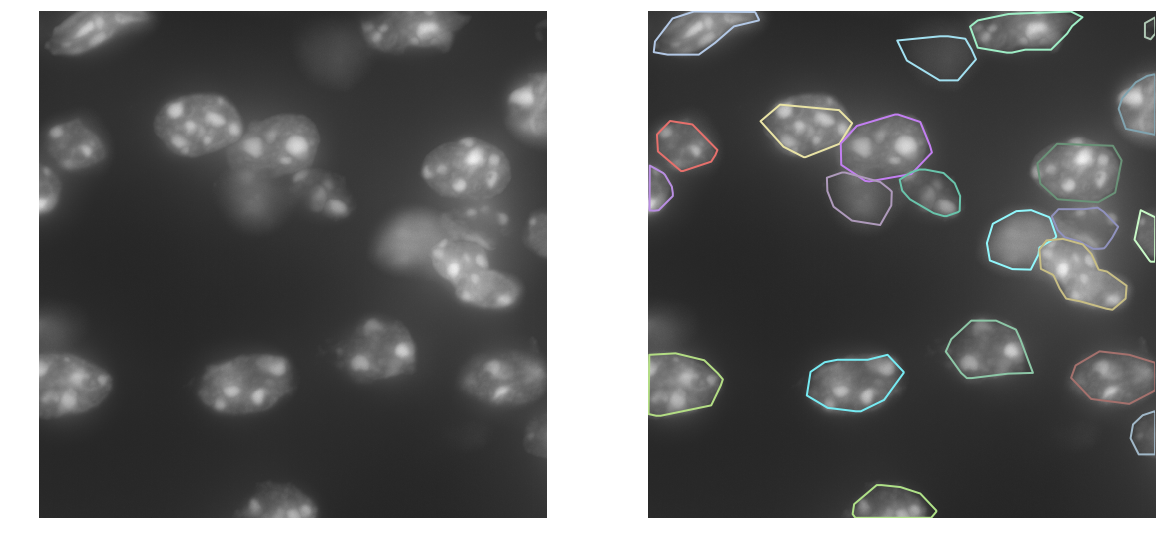

Nuclei_DRG_Hyb2_pos_602.png


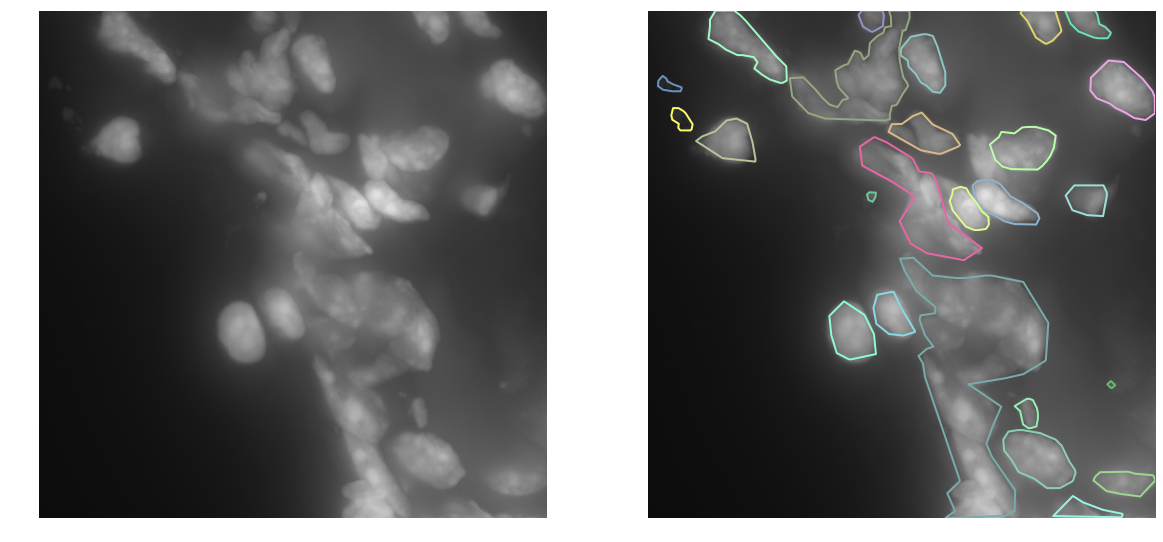

Nuclei_DRG_Hyb2_pos_600.png


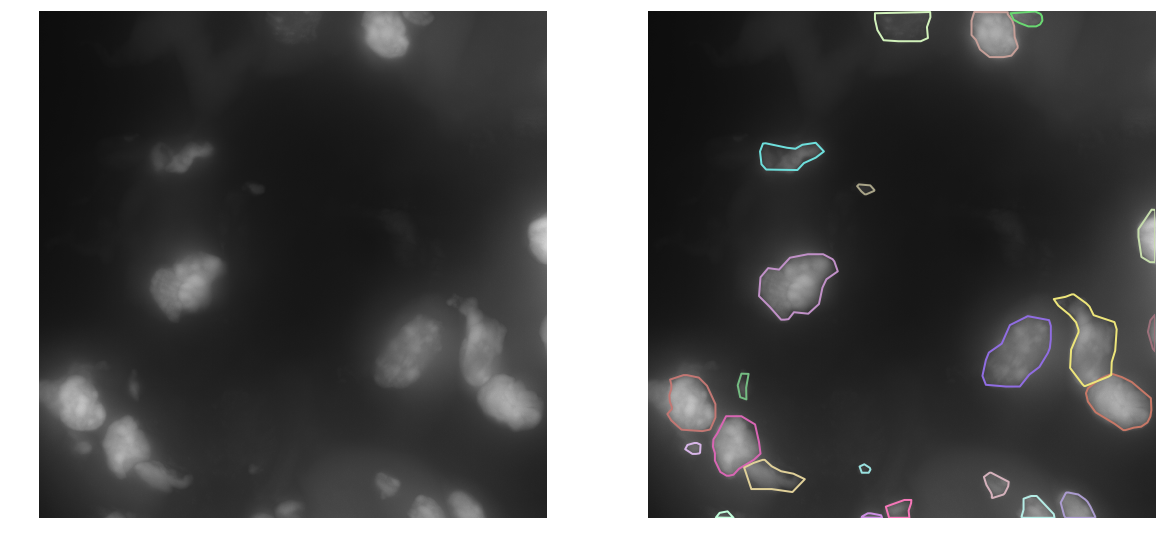

Nuclei_EXP20180416_60X_pos_300.png


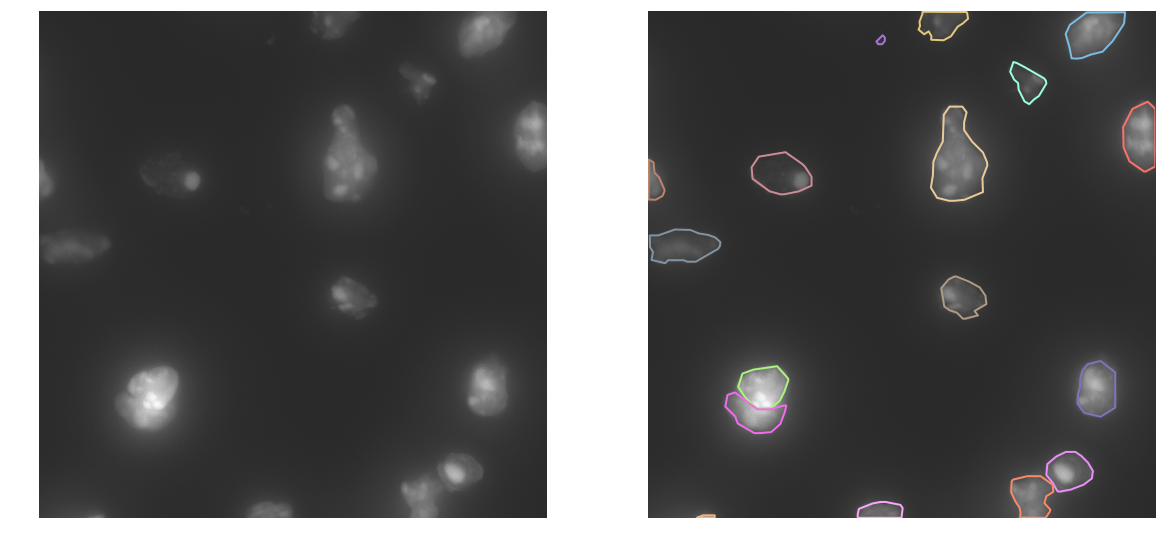

34


In [93]:
###### check chunks
# increasing the size of figures
pylab.rcParams['figure.figsize'] = 20, 12

anno = anno_file
img_dir = NEW_CHUNK_DIR

def check_chunks(anno):
    anno = anno
    data = json.load(open(anno))
    sett = []
    coco = COCO(anno) ; x = 0
    for i,image in enumerate(data['images']):
        if x >= 0:
            pass
        else:
            continue
        x += 1


        img = Image.open(img_dir + image['file_name'])
        print(image['file_name'])
        anno = [obj for obj in data['annotations'] if obj['image_id'] == image['id']]
        boxes = [obj['bbox'] for obj in anno]
        boxes = torch.as_tensor(boxes).reshape(-1,4)
        target = BoxList(boxes, img.size, mode = 'xywh').convert('xyxy')
        #print(image['file_name'], len(anno))
        classes = [obj['category_id'] for obj in data['annotations'] if obj['image_id'] == image['id']]
        json_category_id_to_contiguous_id = {
                v: i + 1 for i, v in enumerate(coco.getCatIds())
        }
        classes = [json_category_id_to_contiguous_id[c] for c in classes]
        classes = torch.tensor(classes)

        target.add_field('labels', classes)
        sett.append(len(anno))
        #continue
        masks = [obj["segmentation"] for obj in anno]
        masks = SegmentationMask(masks, img.size)
        target.add_field("masks", masks)

        target = target.clip_to_image(remove_empty=True)



        polygons = []
        color = []
        boxes = []

        polys = vars(target)['extra_fields']['masks']
        for polygon in polys:
            try:
                tenso = vars(polygon)['polygons'][0]
            except KeyError:
                continue
            c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
            poly1 = tenso.numpy()
            poly = poly1.reshape((int(len(poly1)/2),2))
            polygons.append(Polygon(poly))
            color.append(c)

        xywh_tar = target.convert("xywh")
        for box in vars(xywh_tar)['bbox'].numpy():

            rect = Rectangle((box[0],box[1]), box[2], box[3])
            boxes.append(rect)

        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(img)
        plt.axis('off')

        ax2 = fig.add_subplot(1,2,2)
        plt.imshow(img); plt.axis('off')

        #print(polygons)
        b = PatchCollection(boxes, facecolor = 'none', linewidths = 1, edgecolor = color)
        p = PatchCollection(polygons, facecolor = 'none', linewidths = 0, alpha = 0.4)
        ax2.add_collection(p)
        #ax2.add_collection(b)
        p = PatchCollection(polygons, facecolor = 'none', edgecolors = color, linewidths = 2)
        ax2.add_collection(p)

        #plt.savefig('/home/max/github/nuclei_cell_detect/new_images/BG92_5127_labeled.png', bbox_inches = 'tight')
        plt.show()
    print(max(sett))

check_chunks(anno)

## Pop images from the annotation file that are not significant

In [30]:
def pop_image_from_anno(anno_old, anno_new, list_to_pop):
    data = json.load(open(anno_old))
    to_write_imgs = [i for i in data['images'] if i['id'] not in list_to_pop]
    to_write_anno = [i for i in data['annotations'] if i['image_id'] not in list_to_pop]
    for x, i in enumerate(to_write_imgs):
        
        if i['file_name'] == "Raw_Nuclei_533.png":
            to_write_imgs[x]['id'] = 534
            to_write_imgs[x]['file_name'] = 'Raw_Nuclei_534.png'
            
    for x, i in enumerate(to_write_anno):
        if i['image_id'] == 533:
            to_write_anno[x]['image_id'] = 534
            
    
    with open(anno_new, 'w') as write:
        json.dump(
                {"info":data['info'],
                 "annotations":to_write_anno, 
                 "images":to_write_imgs,
                 "licenses":data['licenses'],
                 "categories":data['categories']}, write)

# list of the image ids, that need to be removed from the annotation file
list_3 = [453, 503, 592, 600, 620, 712, 452, 500, 502, 503, 512, 552, 563, 600, 732, 761]

# create an updated file with the extension _pop.json
pop_image_from_anno(anno, anno[:-5] + '_pop.json', list_3)

[2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727]


In [18]:
# concatenate annotation files

def combine(anno_1, anno_2, anno_comb):
    data1 = json.load(open(anno_1))
    data2 = json.load(open(anno_2))
    img = sum([data1['images'], data2['images']], [])
    annos = sum([data1['annotations'], data2['annotations']], [])
    
    with open(anno_comb, 'w') as write:
        json.dump(
                {"info":data1['info'],
                 "annotations":annos, 
                 "images":img,
                 "licenses":data1['licenses'],
                 "categories":data1['categories']}, write)
    